In [741]:
# General packages
import pandas as pd
import numpy as np
import hvplot.pandas
import datetime as dt

# Packages related to machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from dateutil.relativedelta import relativedelta
    #for nueral networs
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# needed for API
import pandas_datareader as pdr
import yfinance as yfin
yfin.pdr_override()
from dotenv import load_dotenv
import os
import json
import requests

# Sentiment Score
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from urllib.request import urlopen
from urllib.request import Request
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#turn off warning signs for cleaner code
from warnings import filterwarnings
filterwarnings("ignore")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\micha\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [651]:
# Create a function that pulls the needed data for analysis
def vix_analysis ():
    # Set up timeframe for model
    end = dt.date.today()
    start= end - dt.timedelta(days=365*20)
    start_str = start.strftime('%Y-%m-%d')
    end_str = end.strftime('%Y-%m-%d')
    
    # set API pull to vix
    vix = '^VIX'
    df = pdr.data.get_data_yahoo(vix, start=start_str, end=end_str)
    vix_df = pd.DataFrame()
    vix_df['vix_close'] = df[["Close"]]
    vix_df['vix_change'] = vix_df['vix_close'].pct_change()
    vix_df = vix_df.dropna()
    
    # convert data to numpy to be scaled
    x_raw = vix_df["vix_close"].to_numpy()
    x_raw = np.reshape(x_raw, [-1,1])
    
    # scale the data
    scaler = StandardScaler().fit(x_raw)
    x_scaled = scaler.transform(x_raw)
    
    # cluster the data
    cluster_model = KMeans(n_clusters=3, random_state=0).fit(x_scaled)
    vix_df['labels']=cluster_model.labels_

    # indicate how long the VIX has been in it's current state
    vix_df['vix_days_in_label'] = vix_df.groupby(vix_df['labels'].ne(vix_df['labels'].shift()).cumsum()).cumcount()+1
    vix_df['up_down'] = np.where(vix_df['vix_change']>=0,1,-1)
    vix_df['vix_con_direction'] = (vix_df.groupby(vix_df['up_down'].ne(vix_df['up_down'].shift()).cumsum()).cumcount()+1)*vix_df['up_down']
    vix_df = vix_df.drop(columns=['up_down'])
    vix_df.index = vix_df.index.date
    
    # return results
    return vix_df, cluster_model

In [652]:
def spy_analysis ():
    # Set up timeframe for model
    end = dt.date.today()
    start= end - dt.timedelta(days=365*20)
    start_str = start.strftime('%Y-%m-%d')
    end_str = end.strftime('%Y-%m-%d')
    
    # set API pull to SPY
    spy = 'SPY'
    df = pdr.data.get_data_yahoo(spy, start=start_str, end=end_str)
    spy_df = pd.DataFrame()
    spy_df['spy_close'] = df[["Adj Close"]]
    spy_df['spy_change'] = spy_df['spy_close'].pct_change()
    spy_df = spy_df.dropna()
    
    # SPY movement indicators
    spy_df['up_down'] = np.where(spy_df['spy_change']>0,0,1)
    spy_df['spy_con_direction'] = (spy_df.groupby(spy_df['up_down'].ne(spy_df['up_down'].shift()).cumsum()).cumcount()+1)*np.where(spy_df['spy_change']>=0,1,-1)
    spy_df = spy_df.drop(columns=['up_down'])
    spy_df['3_day_change'] = ((spy_df['spy_change']+1).rolling(window=3).apply(np.prod, raw=True)-1)
    spy_df['15_day_change'] = ((spy_df['spy_change']+1).rolling(window=15).apply(np.prod, raw=True)-1)
    spy_df['45_day_change'] = ((spy_df['spy_change']+1).rolling(window=45).apply(np.prod, raw=True)-1)
    spy_df['90_day_change'] = ((spy_df['spy_change']+1).rolling(window=90).apply(np.prod, raw=True)-1)
    spy_df['15_day_stdv'] = spy_df['spy_change'].rolling(window=15).std()
    spy_df['30_day_stdv'] = spy_df['spy_change'].rolling(window=30).std()
    spy_df['60_day_stdv'] = spy_df['spy_change'].rolling(window=60).std()
    spy_df['4sma_pct_price'] = (spy_df['spy_close'].rolling(window=4).mean()/spy_df['spy_close']) - 1
    spy_df['30sma_pct_price'] = (spy_df['spy_close'].rolling(window=30).mean()/spy_df['spy_close']) - 1
    spy_df['100sma_pct_price'] = (spy_df['spy_close'].rolling(window=100).mean()/spy_df['spy_close']) - 1
    spy_df['bolling_top_pct'] = ((spy_df['spy_close'].rolling(window=60).mean()+spy_df['spy_close'].rolling(window=60).std()*2)/spy_df['spy_close']) - 1
    spy_df['bolling_bot_pct'] = ((spy_df['spy_close'].rolling(window=60).mean()-spy_df['spy_close'].rolling(window=60).std()*2)/spy_df['spy_close']) - 1
    spy_df.index = spy_df.index.date
    
    # return results
    return spy_df

In [653]:
def market_sent ():
    # define variables for function
    ticker = 'SPY'
    web_url = 'https://finviz.com/quote.ashx?t='
    news_tables = {}
    
    
    # set up request
    url = web_url + ticker
    req = Request(url=url,headers={"User-Agent": "Chrome"}) 
    response = urlopen(req)    
    html = BeautifulSoup(response,"html.parser")
    news_table = html.find(id='news-table')
   
    # Pull articles to new dataframe
    parsed_news = []
    for x in news_table.findAll('tr'):
        a_element = x.find('a', class_='tab-link-news')
        if a_element is not None:
            text = a_element.get_text()
            date_scrape = x.td.text.split()
            if len(date_scrape) == 1:
                time = date_scrape[0]
            else:
                date = date_scrape[0]
                time = date_scrape[1]
            parsed_news.append([date, time, text])
        
    # Sentiment Analysis portion
    analyzer = SentimentIntensityAnalyzer()

    columns = ['Date', 'Time', 'Headline']
    news = pd.DataFrame(parsed_news, columns=columns,)
    scores = news['Headline'].apply(analyzer.polarity_scores).to_list()

    df_scores = pd.DataFrame(scores)
    news = news.join(df_scores, rsuffix='_right')
    news['Date'] = pd.to_datetime(news['Date'])
    news = news.set_index('Date')
    
    # make final table for that show average sentiment for each day 
    sentiment_df = pd.DataFrame()
    sentiment_df = news.groupby(news.index).mean()
    sentiment_df = sentiment_df[['compound']]
    sentiment_df = sentiment_df.rename(columns={'compound': 'Sentiment'})
    sentiment_df.index = sentiment_df.index.date
    
    return sentiment_df

In [654]:
#test datareader
def get_econ_data ():
    # define data for DataReader
    end = dt.date.today()
    start= end - dt.timedelta(days=365*21)
    start_str = start.strftime('%Y-%m-%d')
    end_str = end.strftime('%Y-%m-%d')

    # select tables, enter as dataframe
    econ_df = pdr.DataReader(['GDPC1','UNRATE','DFF','EFFR','MORTGAGE30US','DTB3','PRIME','MICH','TOTALSA','UMCSENT','HOUST','RECPROUSM156N','REAINTRATREARAT1YE','REAINTRATREARAT10Y'], 'fred', start_str, end_str)
    names = ['real gdp','unemployment','fed fund effective rate', 'effective fed fund rate', '30 year mortgage', '3t-bill market rate', 'prime bank loan rate', 'michigan inflaction pred', 'total car sales','cons sentiment','new housing','recession prob']
    
    #filling blank values with prior value
    econ_df.fillna(method='ffill', inplace=True)
    # calculate pct change
    econ_df2 = econ_df.pct_change()
    econ_df2['RECPROUSM156N']=econ_df['RECPROUSM156N']
    econ_df = econ_df2
    # seporate out daily metrics
    daily_df = econ_df[['DFF', 'EFFR', 'DTB3']]
    econ_df = econ_df.drop(columns=['DFF', 'EFFR', 'DTB3'])
    # replace 0 values with null
    econ_df.replace(0, np.nan, inplace=True)
    # refill nulls with prior value
    econ_df.fillna(method='ffill', inplace=True)
        # add back in daily values
    econ_df = pd.concat([daily_df, econ_df], axis=1)
    # remove inf values
    econ_df[np.isinf(econ_df)] = 0
    # update index to date
    econ_df.index = econ_df.index.date

    return econ_df

In [682]:
def create_variable_tables ():
    spy_df = spy_analysis()
    econ_df = get_econ_data()
    vix_df, cluster_model = vix_analysis()
    sentiment_df = market_sent()

    # Set Up DataFrame for Testing
    X_prep = pd.concat([vix_df, spy_df], axis=1)
    X_prep['y']=X_prep['spy_change'].shift(-1)
    X_prep = X_prep.dropna()
    X_prep = pd.concat([X_prep, econ_df, sentiment_df], axis=1)
    X_prep = X_prep.dropna(subset='spy_close')
    X_prep[np.isnan(X_prep)] = 0

    X_full = X = X_prep.drop(columns=['spy_close','vix_close','y'])
    y_full = y = X_prep['y']*100

    # Create Variable Tables
    X_0 = X_prep[X_prep['labels']==0].drop(columns=['spy_close','vix_close','y'])
    X_1 = X_prep[X_prep['labels']==1].drop(columns=['spy_close','vix_close','y'])
    X_2 = X_prep[X_prep['labels']==2].drop(columns=['spy_close','vix_close','y'])

    y_0 = X_prep[X_prep['labels']==0]['y']*100
    y_1 = X_prep[X_prep['labels']==1]['y']*100
    y_2 = X_prep[X_prep['labels']==2]['y']*100
    
    return X_full, X_0, X_1 , X_2, y_full, y_0, y_1, y_2

X_full, X_0, X_1 , X_2, y_full, y_0, y_1, y_2 = create_variable_tables()
X_full.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,vix_change,labels,vix_days_in_label,vix_con_direction,spy_change,spy_con_direction,3_day_change,15_day_change,45_day_change,90_day_change,...,MORTGAGE30US,PRIME,MICH,TOTALSA,UMCSENT,HOUST,RECPROUSM156N,REAINTRATREARAT1YE,REAINTRATREARAT10Y,Sentiment
2003-09-05,-0.028862,1.0,20.0,-2.0,-0.005609,-1.0,0.000292,0.035445,0.030671,0.120416,...,0.018987,-0.058824,0.12,-0.053444,-0.017917,0.057829,0.02,-0.417762,0.083081,0.0
2003-09-08,0.004953,1.0,21.0,1.0,0.008266,1.0,0.003096,0.040754,0.050030,0.132134,...,0.018987,-0.058824,0.12,-0.053444,-0.017917,0.057829,0.02,-0.417762,0.083081,0.0
2003-09-09,0.032311,1.0,22.0,2.0,-0.006558,-1.0,-0.003965,0.025080,0.022840,0.124832,...,0.018987,-0.058824,0.12,-0.053444,-0.017917,0.057829,0.02,-0.417762,0.083081,0.0
2003-09-10,0.061538,0.0,1.0,3.0,-0.010097,-2.0,-0.008461,0.010906,0.008008,0.097826,...,0.018987,-0.058824,0.12,-0.053444,-0.017917,0.057829,0.02,-0.417762,0.083081,0.0
2003-09-11,-0.037981,1.0,1.0,-1.0,0.002942,1.0,-0.013696,0.018018,0.016703,0.103186,...,0.018987,-0.058824,0.12,-0.053444,-0.017917,0.057829,0.02,-0.417762,0.083081,0.0


In [683]:
X_full, X_0, X_1 , X_2, y_full, y_0, y_1, y_2 = create_variable_tables()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [684]:
def create_train_test ():
    # Define train periods
    X_full, X_0, X_1 , X_2, y_full, y_0, y_1, y_2 = create_variable_tables()
    start_train = X_full.index.min()
    last_day = dt.datetime.strptime('2020-01-01', '%Y-%m-%d').date()
    end_train = last_day

    # Define test period
    start_test = last_day
    end_test = X_full.index.max()


    #Create train Data Frames
    X_full_train = X_full.loc[start_train: end_train]
    X_0_train = X_0.loc[start_train: end_train]
    X_1_train = X_1.loc[start_train: end_train]
    X_2_train = X_2.loc[start_train: end_train]

    y_full_train = y_full.loc[start_train: end_train]
    y_0_train = y_0.loc[start_train: end_train]
    y_1_train = y_1.loc[start_train: end_train]
    y_2_train = y_2.loc[start_train: end_train]

    # Create test DataFrames
    X_full_test = X_full.loc[start_test: end_test]
    X_0_test = X_0.loc[start_test: end_test]
    X_1_test = X_1.loc[start_test: end_test]
    X_2_test = X_2.loc[start_test: end_test]

    y_full_test = y_full.loc[start_test: end_test]
    y_0_test = y_0.loc[start_test: end_test]
    y_1_test = y_1.loc[start_test: end_test]
    y_2_test = y_2.loc[start_test: end_test]
    
    return X_full_train, X_0_train, X_1_train, X_2_train, y_full_train, y_0_train, y_1_train, y_2_train, X_full_test, X_0_test, X_1_test, X_2_test, y_full_test, y_0_test, y_1_test, y_2_test

In [685]:
X_full_train, X_0_train, X_1_train, X_2_train, y_full_train, y_0_train, y_1_train, y_2_train, X_full_test, X_0_test, X_1_test, X_2_test, y_full_test, y_0_test, y_1_test, y_2_test = create_train_test()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [686]:
def scale_x_data ():
    # fit Scale X Variables
    X_full_train, X_0_train, X_1_train, X_2_train, y_full_train, y_0_train, y_1_train, y_2_train, X_full_test, X_0_test, X_1_test, X_2_test, y_full_test, y_0_test, y_1_test, y_2_test = create_train_test()
    scaler = StandardScaler()
    X_full_scaler = scaler.fit(X_full_train, random_state=1)
    X_0_scaler = scaler.fit(X_0_train, random_state=1)
    X_1_scaler = scaler.fit(X_1_train, random_state=1)
    X_2_scaler = scaler.fit(X_2_train, random_state=1)

    # Scale X Variables
    X_full_train_scaled = X_full_scaler.transform(X_full_train)
    X_0_train_scaled = X_0_scaler.transform(X_0_train)
    X_1_train_scaled = X_1_scaler.transform(X_1_train)
    X_2_train_scaled = X_2_scaler.transform(X_2_train)

    X_full_test_scaled = X_full_scaler.transform(X_full_test)
    X_0_test_scaled = X_0_scaler.transform(X_0_test)
    X_1_test_scaled = X_1_scaler.transform(X_1_test)
    X_2_test_scaled = X_2_scaler.transform(X_2_test)
    
    return X_full_train_scaled, X_0_train_scaled, X_1_train_scaled, X_2_train_scaled, X_full_test_scaled, X_0_test_scaled, X_1_test_scaled, X_2_test_scaled

In [742]:
# fit Scale X Variables
scaler = StandardScaler()
X_full_scaler = scaler.fit(X_full_train)
X_0_scaler = scaler.fit(X_0_train)
X_1_scaler = scaler.fit(X_1_train)
X_2_scaler = scaler.fit(X_2_train)

# Scale X Variables
X_full_train_scaled = X_full_scaler.transform(X_full_train)
X_0_train_scaled = X_0_scaler.transform(X_0_train)
X_1_train_scaled = X_1_scaler.transform(X_1_train)
X_2_train_scaled = X_2_scaler.transform(X_2_train)

X_full_test_scaled = X_full_scaler.transform(X_full_test)
X_0_test_scaled = X_0_scaler.transform(X_0_test)
X_1_test_scaled = X_1_scaler.transform(X_1_test)
X_2_test_scaled = X_2_scaler.transform(X_2_test)

# Create nueral network
nn = Sequential()

# add first hidden layer
nn.add(Dense(units=16, input_dim=33, activation="relu"))
# add second hidden layer
nn.add(Dense(units=8, activation="relu"))
# add third hidden layer
nn.add(Dense(units=4, activation="relu"))
# add fourth hidden layer
nn.add(Dense(units=2, activation="relu"))
# Output layer
nn.add(Dense(units=1, activation="linear"))

# Compile the model
nn.compile(loss="mean_squared_error", optimizer='adam', metrics=["mse"])

# Fit the model
model_full = nn.fit(X_full_train, y_full_train, epochs=100, batch_size=22)

Epoch 1/100
187/187 [==============================] - 2s 3ms/step - loss: 21.0632 - mse: 21.0632
Epoch 2/100
187/187 [==============================] - 1s 3ms/step - loss: 1.2872 - mse: 1.2872
Epoch 3/100
187/187 [==============================] - 1s 3ms/step - loss: 1.2683 - mse: 1.2683
Epoch 4/100
187/187 [==============================] - 1s 3ms/step - loss: 1.2668 - mse: 1.2668
Epoch 5/100
187/187 [==============================] - 1s 3ms/step - loss: 1.2669 - mse: 1.2669
Epoch 6/100
187/187 [==============================] - 0s 3ms/step - loss: 1.2671 - mse: 1.2671
Epoch 7/100
187/187 [==============================] - 1s 3ms/step - loss: 1.2676 - mse: 1.2676
Epoch 8/100
187/187 [==============================] - 1s 3ms/step - loss: 1.2677 - mse: 1.2677
Epoch 9/100
187/187 [==============================] - 1s 3ms/step - loss: 1.2678 - mse: 1.2678
Epoch 10/100
187/187 [==============================] - 1s 3ms/step - loss: 1.2680 - mse: 1.2680
Epoch 11/100
187/187 [===============

26/26 [==============================] - 0s 3ms/step
0.23020706455542023
        pred      real    adjust      base  p  r  call
30  0.026134 -0.257681  0.257681  0.026134  1 -1     0
31  0.026134  0.478090 -0.478090  0.026134  1  1     1
32  0.026134 -0.410821  0.410821  0.026134  1 -1     0
33  0.026134 -1.029821  1.029821  0.026134  1 -1     0
34  0.026134 -3.316553  3.316553  0.026134  1 -1     0
35 -0.907902  0.340989  0.340989 -0.907902 -1  1     0
36 -0.784331 -1.454971 -1.454971 -0.784331 -1 -1     1
37  0.160988 -0.787073  0.787073  0.160988  1 -1     0
38  0.160988  1.611509 -1.611509  0.160988  1  1     1
39  0.160988 -0.050510  0.050510  0.160988  1 -1     0
40 -0.171199  0.405343  0.405343 -0.171199 -1  1     0
41 -0.043875  1.079906  1.079906 -0.043875 -1  1     0
42 -0.230795  1.435316  1.435316 -0.230795 -1  1     0
43 -0.045417 -0.059047 -0.059047 -0.045417 -1 -1     1
44 -0.009932  0.115716  0.115716 -0.009932 -1  1     0
45  0.058386  0.474688 -0.474688  0.058386  1  

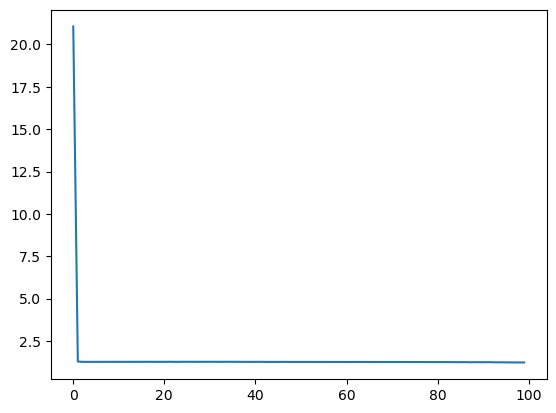

In [745]:
# Evaluate the model loss and accuracy metrics using the evaluate method and the test data
model_loss, model_accuracy = nn.evaluate(X_full_test, y_full_test)

y_pred = nn.predict(X_full_test)
pred_df = pd.DataFrame()
y_pred = pd.DataFrame(y_pred)
pred_df['pred']=y_pred
real = pd.DataFrame(y_1_test.values)
pred_df['real'] = real
new_df = pd.DataFrame(X_full_test)
pred_df.head(65)

pred_df['adjust'] = np.where(pred_df['pred']>0,pred_df['real']*-1,pred_df['real']*(1))
pred_df['base'] = np.where(abs(pred_df['pred'])>15,0,pred_df['pred'])
pred_df['p'] = np.where(pred_df['pred']>=0,1,-1)
pred_df['r'] = np.where(pred_df['real']>=0,1,-1)
pred_df['call'] = np.where(pred_df['p']==pred_df['r'],1,0)

prod = (1+pred_df/100).cumprod()-1
prod[100:200].hvplot()

print(pred_df['call'].sum()/pred_df['call'].count())

prod = (1+pred_df/100).cumprod()-1

print(pred_df[30:90].head(50))
prod[30:90].hvplot(y=["adjust","real","base"])

In [732]:
import matplotlib.pyplot as plt
plt.plot(model_full.history["loss"])
plt.show()

,vix_change,labels,vix_days_in_label,vix_con_direction,spy_change,spy_con_direction,3_day_change,15_day_change,45_day_change,90_day_change,...,MORTGAGE30US,PRIME,MICH,TOTALSA,UMCSENT,HOUST,RECPROUSM156N,REAINTRATREARAT1YE,REAINTRATREARAT10Y,Sentiment
2020-01-02,-0.095065,1.0,59.0,-2.0,0.009352,2.0,0.006226,0.041263,0.076384,0.151395,...,-0.005348,-0.05,0.086957,-0.012885,0.005035,0.020156,0.26,1.060426,-0.017829,0.0
2020-01-03,0.124298,1.0,60.0,1.0,-0.007572,-1.0,0.004142,0.030453,0.068550,0.130178,...,-0.005348,-0.05,0.086957,-0.012885,0.005035,0.020156,0.26,1.060426,-0.017829,0.0
2020-01-06,-0.012126,1.0,61.0,-1.0,0.003815,1.0,0.005530,0.025545,0.069347,0.138959,...,-0.005348,-0.05,0.086957,-0.012885,0.005035,0.020156,0.26,1.060426,-0.017829,0.0
2020-01-07,-0.004332,1.0,62.0,-2.0,-0.002812,-1.0,-0.006587,0.022049,0.069188,0.127815,...,-0.005348,-0.05,0.086957,-0.012885,0.005035,0.020156,0.26,1.060426,-0.017829,0.0
2020-01-08,-0.024656,1.0,63.0,-3.0,0.005330,1.0,0.006328,0.020486,0.065020,0.119526,...,-0.005348,-0.05,0.086957,-0.012885,0.005035,0.020156,0.26,1.060426,-0.017829,0.0


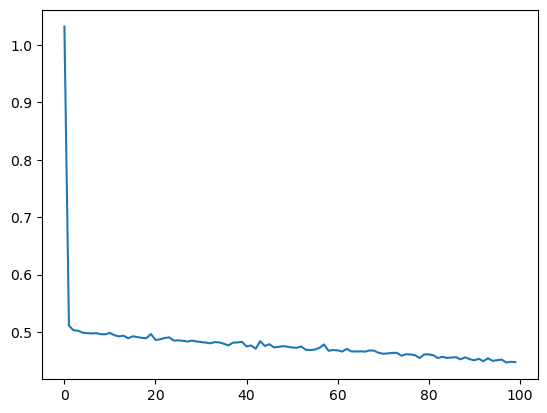